In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

# - pickle: For saving and loading trained models
# - skimage: For advanced image feature extraction (HOG, LBP, etc.)

# 1. extracting the data from the zip file and prepare the data

In [ ]:
import zipfile


zip_path = "ZIP_cropped_objectsV3.zip"     # Change this to your actual zip file name
extract_dir = "dataset"           # Where to extract your files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
dataset_path = "dataset"  # Example: "C:/Users/YourName/road_dataset"

# Create paths for each split
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# Display the paths to verify
print("Dataset paths configured:")
print(f"  Train: {train_path}")
print(f"  Valid: {valid_path}")
print(f"  Test: {test_path}")
print("\nNote: the images should be 64x64 grayscale")
print("Make sure these paths exist on your computer!")

Dataset paths configured:
  Train: dataset/train
  Valid: dataset/valid
  Test: dataset/test

Note: the images should be 64x64 grayscale
Make sure these paths exist on your computer!


In [ ]:
class_names = sorted(os.listdir(train_path))
print(f"✓ Found {len(class_names)} classes: {class_names}")

# Count how many images are in each class
print("\nDataset Statistics (Training Set):")
print("-" * 40)
for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)

    # Count image files
    image_files = [f for f in os.listdir(class_folder)
                   if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    num_images = len(image_files)

    print(f"  {class_name}: {num_images} images")
print("-" * 40)

print("\nThis helps understand if your dataset is balanced.")
print("For Logistic Regression, balanced classes work best!")

✓ Found 7 classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']

Dataset Statistics (Training Set):
----------------------------------------
  bicycles: 46 images
  buses: 88 images
  crosswalks: 157 images
  fire hydrants: 60 images
  motorcycles: 158 images
  traffic lights: 459 images
  vehicles: 763 images
----------------------------------------

This helps understand if your dataset is balanced.
For Logistic Regression, balanced classes work best!


In [ ]:
def load_grayscale_images(base_path, class_names, target_size=(64, 64)):
    """
    Loads grayscale images from organized folders

    Parameters:
    - base_path: Path to train/valid/test folder
    - class_names: List of class names
    - target_size: Resize images to this size (default: 64x64)

    Returns:
    - images: List of grayscale image arrays
    - labels: List of corresponding class names
    """
    images = []
    labels = []

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(base_path, class_name)

        # Get all image files
        image_files = [f for f in os.listdir(class_folder)
                      if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        # Load each image
        for img_file in image_files:
            img_path = os.path.join(class_folder, img_file)

            # Read image in GRAYSCALE mode (0 flag means grayscale)
            img = cv2.imread(img_path, 0)

            if img is not None:
                # Resize to target size if needed
                if img.shape != target_size:
                    img = cv2.resize(img, target_size)

                images.append(img)
                labels.append(class_name)

    return images, labels

print("✓ Grayscale image loading function defined!")
print("This function ensures all images are:")
print("  - Loaded in grayscale mode")
print("  - Resized to 64x64 pixels")
print("  - Properly organized with their labels")

✓ Grayscale image loading function defined!
This function ensures all images are:
  - Loaded in grayscale mode
  - Resized to 64x64 pixels
  - Properly organized with their labels


In [ ]:
print("⏳ Loading training images...")
train_images, train_labels = load_grayscale_images(train_path, class_names, target_size=(64, 64))
print(f"✓ Loaded {len(train_images)} training images")

# Load validation images
print("\n⏳ Loading validation images...")
valid_images, valid_labels = load_grayscale_images(valid_path, class_names, target_size=(64, 64))
print(f"✓ Loaded {len(valid_images)} validation images")

# Load test images
print("\n⏳ Loading test images...")
test_images, test_labels = load_grayscale_images(test_path, class_names, target_size=(64, 64))
print(f"✓ Loaded {len(test_images)} test images")

# Verify image shape
if len(train_images) > 0:
    print(f"\n✓ Image shape verification: {train_images[0].shape}")
    print(f"  Expected: (64, 64) for grayscale")
    if train_images[0].shape == (64, 64):
        print("  ✓ Correct format!")
    else:
        print("  ⚠ Warning: Unexpected shape!")

# Summary
print("\n" + "="*50)
print("DATASET LOADING COMPLETE!")
print("="*50)
print(f"Total images: {len(train_images) + len(valid_images) + len(test_images)}")
print(f"  - Training: {len(train_images)}")
print(f"  - Validation: {len(valid_images)}")
print(f"  - Test: {len(test_images)}")
print("="*50)

⏳ Loading training images...
✓ Loaded 1731 training images

⏳ Loading validation images...
✓ Loaded 798 validation images

⏳ Loading test images...
✓ Loaded 506 test images

✓ Image shape verification: (64, 64)
  Expected: (64, 64) for grayscale
  ✓ Correct format!

DATASET LOADING COMPLETE!
Total images: 3035
  - Training: 1731
  - Validation: 798
  - Test: 506


📊 Creating visualization of sample grayscale images...


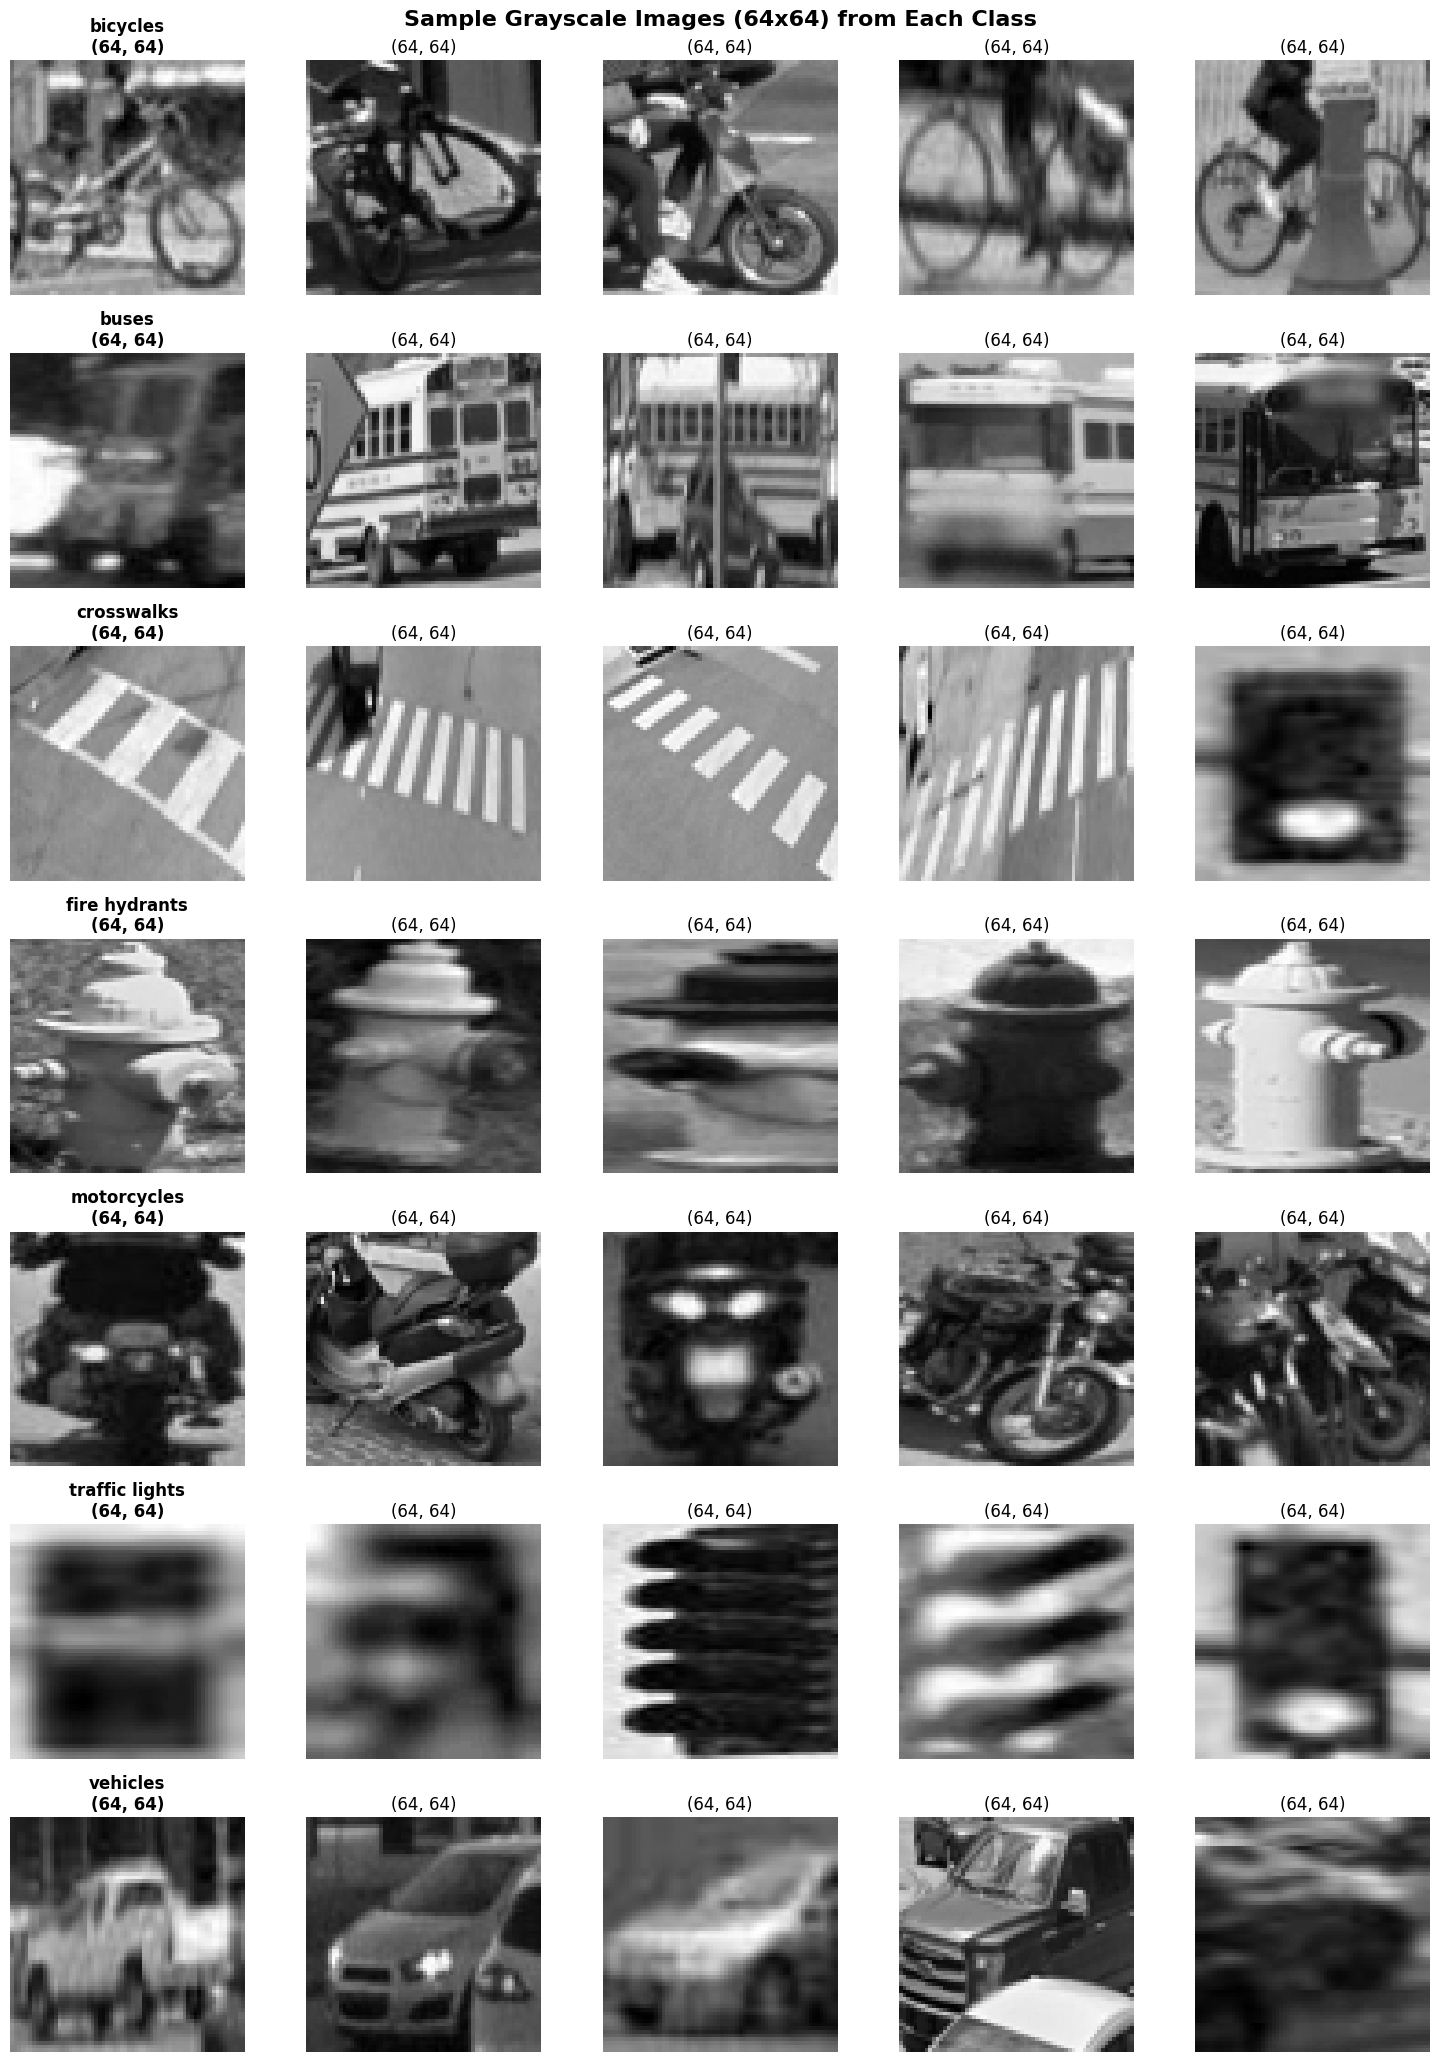

✓ Visualization complete!

Note: Images are displayed in grayscale (black & white)
This is perfect for feature extraction like HOG and LBP!


In [ ]:
print("📊 Creating visualization of sample grayscale images...")

# Create a grid: one row per class, 5 columns for samples
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3*len(class_names)))
fig.suptitle('Sample Grayscale Images (64x64) from Each Class',
             fontsize=16, fontweight='bold')

# Loop through each class
for i, class_name in enumerate(class_names):
    # Get indices of all images belonging to this class
    class_indices = [idx for idx, label in enumerate(train_labels) if label == class_name]

    # Display up to 5 sample images
    for j in range(min(5, len(class_indices))):
        idx = class_indices[j]
        img = train_images[idx]

        # Handle single class vs multiple classes
        ax = axes[i, j] if len(class_names) > 1 else axes[j]

        # Display grayscale image
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        # Add title with class name and shape
        if j == 0:
            ax.set_title(f'{class_name}\n{img.shape}', fontweight='bold')
        else:
            ax.set_title(f'{img.shape}')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")
print("\nNote: Images are displayed in grayscale (black & white)")
print("This is perfect for feature extraction like HOG and LBP!")

# Feature Engineering (HOG + LBP + Stats)

# 1. HOG (Histogram of Oriented Gradients):
    - Captures edge directions and shapes
    - Great for object detection
    - Describes texture patterns
#
# 2. LBP (Local Binary Pattern):
    - Captures local texture information
    - Robust to lighting changes
    - Describes surface patterns

# 3. Statistical Features:
    - Mean intensity (brightness)
    - Standard deviation (contrast)
    - Skewness (asymmetry of pixel distribution)
    - Kurtosis (tailedness of distribution)

# 4. Raw Pixel Features (optional):
    - Flattened pixel values
    - Direct image representation

In [ ]:
def extract_engineered_features(image):
    """
    Extracts multiple engineered features from a grayscale image

    Parameters:
    - image: Grayscale image (64x64)

    Returns:
    - Combined feature vector
    """
    features_list = []

    # === 1. HOG FEATURES ===
    # HOG captures edge orientations and gradients
    hog_features = hog(
        image,
        orientations=9,          # Number of orientation bins
        pixels_per_cell=(8, 8),  # Cell size
        cells_per_block=(2, 2),  # Block size
        visualize=False,         # We don't need visualization here
        feature_vector=True      # Return as 1D vector
    )
    features_list.append(hog_features)

    # === 2. LBP FEATURES ===
    # LBP captures local texture patterns
    radius = 3                   # Radius of circle
    n_points = 8 * radius        # Number of points on circle
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Create histogram of LBP values (texture descriptor)
    lbp_hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, n_points + 3),
                               range=(0, n_points + 2))
    # Normalize histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Add small value to avoid division by zero
    features_list.append(lbp_hist)

    # === 3. STATISTICAL FEATURES ===
    # Basic statistical properties of pixel intensities
    mean = np.mean(image)
    std = np.std(image)

    # Flatten image for further statistics
    flat_img = image.flatten()

    # Skewness: measure of asymmetry
    skewness = np.mean(((flat_img - mean) / (std + 1e-7)) ** 3)

    # Kurtosis: measure of tailedness
    kurtosis = np.mean(((flat_img - mean) / (std + 1e-7)) ** 4)

    # Combine statistical features
    stats_features = np.array([mean, std, skewness, kurtosis])
    features_list.append(stats_features)

    # === 4. RAW PIXEL FEATURES (OPTIONAL - can make feature vector very long) ===
    # Uncomment the next line if you want to include raw pixels
    # features_list.append(image.flatten())

    # Combine all features into one vector
    combined_features = np.concatenate(features_list)

    return combined_features

print("✓ Engineered features extraction function defined!")
print("\nFeatures being extracted:")
print("  1. HOG (Histogram of Oriented Gradients)")
print("  2. LBP (Local Binary Pattern)")
print("  3. Statistical Features (mean, std, skewness, kurtosis)")
print("  4. Raw pixels (optional - currently disabled)")
print("\nThese features capture shape, texture, and intensity patterns!")

✓ Engineered features extraction function defined!

Features being extracted:
  1. HOG (Histogram of Oriented Gradients)
  2. LBP (Local Binary Pattern)
  3. Statistical Features (mean, std, skewness, kurtosis)
  4. Raw pixels (optional - currently disabled)

These features capture shape, texture, and intensity patterns!


# we try it on one image example

In [ ]:
print("🔍 Testing feature extraction on a sample image...")
print()

# Get a sample image
sample_img = train_images[0]
print(f"Sample image shape: {sample_img.shape}")

# Extract features
sample_features = extract_engineered_features(sample_img)

print(f"\n✓ Feature extraction successful!")
print(f"  Feature vector length: {len(sample_features)}")
print()

# Break down feature components
# Calculate individual feature sizes
hog_size = hog(sample_img, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), visualize=False, feature_vector=True).shape[0]
lbp_size = 8 * 3 + 2  # LBP uniform histogram size
stats_size = 4  # mean, std, skewness, kurtosis

print("Feature vector breakdown:")
print(f"  HOG features:         {hog_size} values")
print(f"  LBP features:         {lbp_size} values")
print(f"  Statistical features: {stats_size} values")
print(f"  {'─'*40}")
print(f"  Total features:       {hog_size + lbp_size + stats_size} values")
print()
print("✓ These features will be used to train Logistic Regression!")

🔍 Testing feature extraction on a sample image...

Sample image shape: (64, 64)

✓ Feature extraction successful!
  Feature vector length: 1794

Feature vector breakdown:
  HOG features:         1764 values
  LBP features:         26 values
  Statistical features: 4 values
  ────────────────────────────────────────
  Total features:       1794 values

✓ These features will be used to train Logistic Regression!


📊 Creating HOG feature visualization...


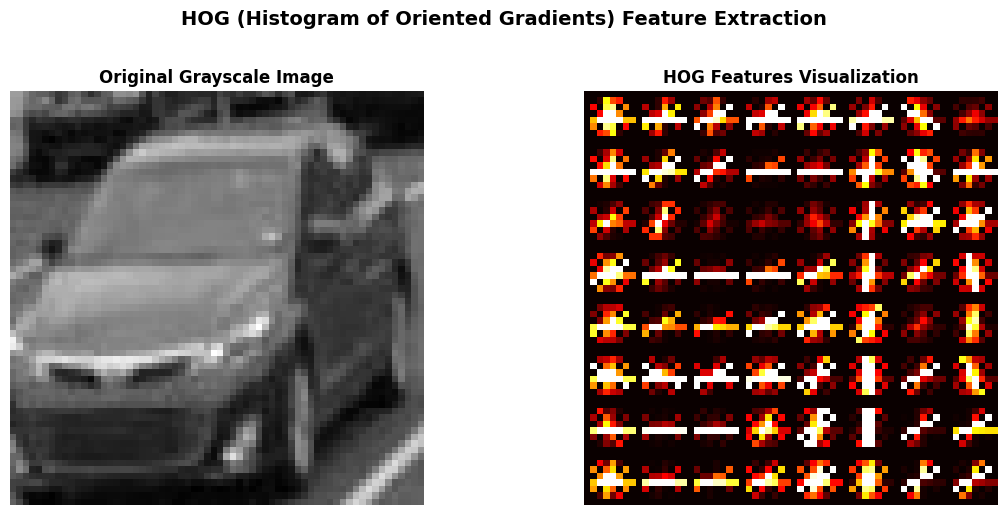

✓ HOG visualization complete!

Interpretation:
  - HOG highlights edges and gradients in the image
  - Bright areas = strong edge orientations
  - These patterns help identify object shapes
  - Perfect for distinguishing different road objects!


In [ ]:
print("📊 Creating HOG feature visualization...")

# Extract HOG with visualization enabled
sample_img = train_images[1111] #222 cross walk
hog_features, hog_image = hog(
    sample_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,          # Enable visualization
    feature_vector=True
)

# Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Original image
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Original Grayscale Image', fontweight='bold', fontsize=12)
axes[0].axis('off')

# Right: HOG visualization
axes[1].imshow(hog_image_rescaled, cmap='hot')
axes[1].set_title('HOG Features Visualization', fontweight='bold', fontsize=12)
axes[1].axis('off')

plt.suptitle('HOG (Histogram of Oriented Gradients) Feature Extraction',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ HOG visualization complete!")
print("\nInterpretation:")
print("  - HOG highlights edges and gradients in the image")
print("  - Bright areas = strong edge orientations")
print("  - These patterns help identify object shapes")
print("  - Perfect for distinguishing different road objects!")

📊 Creating LBP feature visualization...


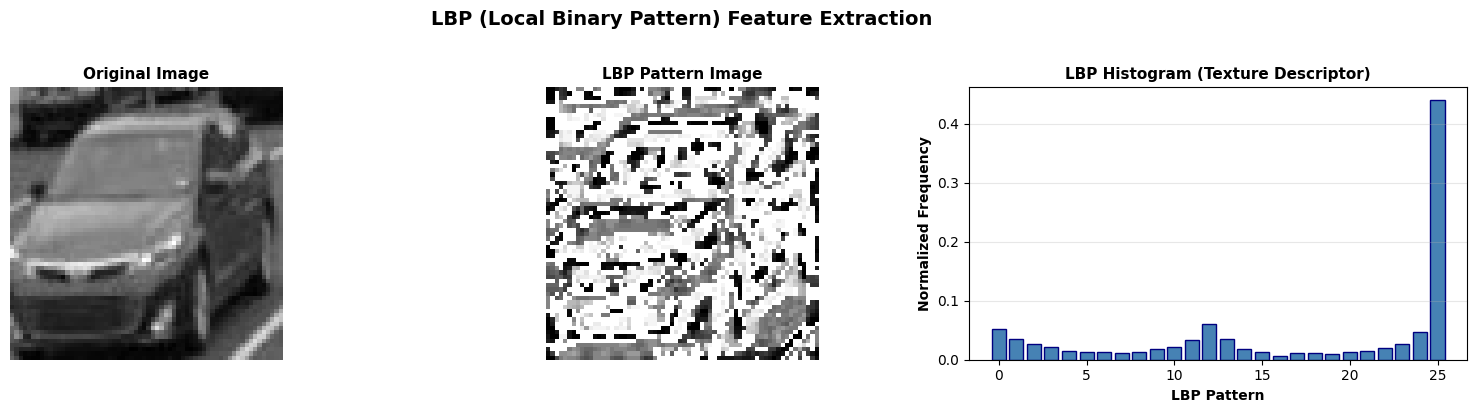

✓ LBP visualization complete!

Interpretation:
  - LBP encodes local texture information
  - Each pixel is compared with its circular neighborhood
  - The histogram represents the distribution of texture patterns
  - Robust to illumination changes!
  - Great for texture-based classification!


In [ ]:
print("📊 Creating LBP feature visualization...")

# Extract LBP
sample_img = train_images[1111]
radius = 3
n_points = 8 * radius

lbp = local_binary_pattern(sample_img, n_points, radius, method='uniform')

# Create LBP histogram
lbp_hist, bins = np.histogram(lbp.ravel(),
                              bins=np.arange(0, n_points + 3),
                              range=(0, n_points + 2))
lbp_hist = lbp_hist.astype("float")
lbp_hist /= (lbp_hist.sum() + 1e-7)

# Create visualization with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Left: Original image
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Original Image', fontweight='bold', fontsize=11)
axes[0].axis('off')

# Middle: LBP pattern
axes[1].imshow(lbp, cmap='gray')
axes[1].set_title('LBP Pattern Image', fontweight='bold', fontsize=11)
axes[1].axis('off')

# Right: LBP histogram
axes[2].bar(range(len(lbp_hist)), lbp_hist, color='steelblue', edgecolor='navy')
axes[2].set_title('LBP Histogram (Texture Descriptor)', fontweight='bold', fontsize=11)
axes[2].set_xlabel('LBP Pattern', fontweight='bold')
axes[2].set_ylabel('Normalized Frequency', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('LBP (Local Binary Pattern) Feature Extraction',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ LBP visualization complete!")
print("\nInterpretation:")
print("  - LBP encodes local texture information")
print("  - Each pixel is compared with its circular neighborhood")
print("  - The histogram represents the distribution of texture patterns")
print("  - Robust to illumination changes!")
print("  - Great for texture-based classification!")

# extracting the features from all the sets (train valid test)

In [ ]:
print("⏳ Extracting engineered features from all images...")
print("This will take a moment (HOG and LBP are computationally intensive)...\n")

# ===== TRAINING SET =====
print("📦 Processing training images...")
X_train = []
for i, img in enumerate(train_images):
    features = extract_engineered_features(img)
    X_train.append(features)

    # Progress indicator every 100 images
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(train_images)} images...")

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(train_labels)

print(f"✓ X_train shape: {X_train.shape}")
print(f"  → {X_train.shape[0]} images, {X_train.shape[1]} features each")
print(f"✓ y_train shape: {y_train.shape}")

# ===== VALIDATION SET =====
print("\n📦 Processing validation images...")
X_valid = []
for i, img in enumerate(valid_images):
    features = extract_engineered_features(img)
    X_valid.append(features)

    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(valid_images)} images...")

X_valid = np.array(X_valid)
y_valid = np.array(valid_labels)

print(f"✓ X_valid shape: {X_valid.shape}")
print(f"  → {X_valid.shape[0]} images, {X_valid.shape[1]} features each")
print(f"✓ y_valid shape: {y_valid.shape}")

# ===== TEST SET =====
print("\n📦 Processing test images...")
X_test = []
for i, img in enumerate(test_images):
    features = extract_engineered_features(img)
    X_test.append(features)

    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(test_images)} images...")

X_test = np.array(X_test)
y_test = np.array(test_labels)

print(f"✓ X_test shape: {X_test.shape}")
print(f"  → {X_test.shape[0]} images, {X_test.shape[1]} features each")
print(f"✓ y_test shape: {y_test.shape}")

# Summary
print("\n" + "="*60)
print("FEATURE EXTRACTION COMPLETE!")
print("="*60)
print("All images converted to engineered feature vectors")
print("Features include: HOG + LBP + Statistical properties")
print("Ready for Logistic Regression training! 🚀")
print("="*60)

⏳ Extracting engineered features from all images...
This will take a moment (HOG and LBP are computationally intensive)...

📦 Processing training images...
  Processed 100/1731 images...
  Processed 200/1731 images...
  Processed 300/1731 images...
  Processed 400/1731 images...
  Processed 500/1731 images...
  Processed 600/1731 images...
  Processed 700/1731 images...
  Processed 800/1731 images...
  Processed 900/1731 images...
  Processed 1000/1731 images...
  Processed 1100/1731 images...
  Processed 1200/1731 images...
  Processed 1300/1731 images...
  Processed 1400/1731 images...
  Processed 1500/1731 images...
  Processed 1600/1731 images...
  Processed 1700/1731 images...
✓ X_train shape: (1731, 1794)
  → 1731 images, 1794 features each
✓ y_train shape: (1731,)

📦 Processing validation images...
  Processed 100/798 images...
  Processed 200/798 images...
  Processed 300/798 images...
  Processed 400/798 images...
  Processed 500/798 images...
  Processed 600/798 images...
  P

# Explanation:
 Standardization is CRITICAL for Logistic Regression!

# Why standardize?
 - Different features have different scales
   (HOG: 0-1, LBP: 0-1, pixel mean: 0-255)
 - Logistic Regression is sensitive to feature scales
 - Standardization makes all features have:
   • Mean = 0
   • Standard deviation = 1

In [ ]:
print("📊 Standardizing features (zero mean, unit variance)...")
print()

# Create a StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data ONLY
print("⏳ Fitting scaler on training data...")
scaler.fit(X_train)
print("✓ Scaler fitted!")

# Transform all datasets using the fitted scaler
print("\n⏳ Transforming datasets...")
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
print("✓ All datasets transformed!")

# Verify standardization
print("\n" + "="*60)
print("STANDARDIZATION RESULTS")
print("="*60)
print("\nBEFORE standardization (original X_train):")
print(f"  Mean: {X_train.mean():.4f}")
print(f"  Std:  {X_train.std():.4f}")
print(f"  Min:  {X_train.min():.4f}")
print(f"  Max:  {X_train.max():.4f}")

print("\nAFTER standardization (scaled X_train):")
print(f"  Mean: {X_train_scaled.mean():.4f}  (should be ~0)")
print(f"  Std:  {X_train_scaled.std():.4f}  (should be ~1)")
print(f"  Min:  {X_train_scaled.min():.4f}")
print(f"  Max:  {X_train_scaled.max():.4f}")
print("="*60)

print("\n✓ Features standardized successfully!")
print("Now all features are on the same scale for Logistic Regression!")

📊 Standardizing features (zero mean, unit variance)...

⏳ Fitting scaler on training data...
✓ Scaler fitted!

⏳ Transforming datasets...
✓ All datasets transformed!

STANDARDIZATION RESULTS

BEFORE standardization (original X_train):
  Mean: 0.2036
  Std:  2.6498
  Min:  -2.5786
  Max:  209.8872

AFTER standardization (scaled X_train):
  Mean: -0.0000  (should be ~0)
  Std:  1.0000  (should be ~1)
  Min:  -4.4414
  Max:  17.5549

✓ Features standardized successfully!
Now all features are on the same scale for Logistic Regression!


# Model Training

In [ ]:
print("🤖 Training Multinomial Logistic Regression model...")
print()

# Create Logistic Regression classifier
lr_model = LogisticRegression(
    multi_class='multinomial',   # Multinomial for multi-class classification
    solver='lbfgs',              # Limited-memory BFGS algorithm
    max_iter=1000,               # Maximum iterations
    C=1.0,                       # Inverse regularization strength
    random_state=42,             # For reproducibility
    verbose=1                    # Show training progress
)

print("Training in progress...")
print()

# Train the model on standardized training data
lr_model.fit(X_train_scaled, y_train)

print()
print("✓ Model trained successfully!")
print()
print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"  Model Type: Logistic Regression (Multinomial)")
print(f"  Solver: L-BFGS")
print(f"  Regularization (C): {lr_model.C}")
print(f"  Max Iterations: {lr_model.max_iter}")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Features per sample: {X_train_scaled.shape[1]}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Iterations until convergence: {lr_model.n_iter_[0]}")
print("="*60)
print()
print("The model is ready to make predictions! 🎯")

🤖 Training Multinomial Logistic Regression model...

Training in progress...



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✓ Model trained successfully!

MODEL SUMMARY
  Model Type: Logistic Regression (Multinomial)
  Solver: L-BFGS
  Regularization (C): 1.0
  Max Iterations: 1000
  Training samples: 1731
  Features per sample: 1794
  Number of classes: 7
  Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  Iterations until convergence: 94

The model is ready to make predictions! 🎯


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


In [ ]:
print("📈 Evaluating model on validation set...")
print()

# Make predictions on validation set
print("⏳ Making predictions...")
y_valid_pred = lr_model.predict(X_valid_scaled)
print("✓ Predictions complete!")

# Calculate accuracy
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print()
print("="*60)
print("VALIDATION RESULTS")
print("="*60)
print(f"Overall Accuracy: {valid_accuracy*100:.2f}%")
print(f"Correct Predictions: {int(valid_accuracy * len(y_valid))}/{len(y_valid)}")
print(f"Incorrect Predictions: {len(y_valid) - int(valid_accuracy * len(y_valid))}/{len(y_valid)}")
print("="*60)

# Detailed classification report
print("\n📊 Detailed Classification Report:")
print("-"*60)
print(classification_report(y_valid, y_valid_pred))

# Explanation
print("\n📖 Metrics Explanation:")
print("  • Precision: When model predicts a class, % of times it's correct")
print("  • Recall: Of all actual examples of a class, % model found")
print("  • F1-score: Balance between precision and recall (harmonic mean)")
print("  • Support: Number of actual examples of each class")
print()
print("Higher values = Better performance (max = 1.00 or 100%)")

📈 Evaluating model on validation set...

⏳ Making predictions...
✓ Predictions complete!

VALIDATION RESULTS
Overall Accuracy: 73.81%
Correct Predictions: 589/798
Incorrect Predictions: 209/798

📊 Detailed Classification Report:
------------------------------------------------------------
                precision    recall  f1-score   support

      bicycles       0.62      0.36      0.45        14
         buses       0.19      0.36      0.25        11
    crosswalks       0.67      0.63      0.65        46
 fire hydrants       0.36      0.73      0.48        11
   motorcycles       0.58      0.63      0.61        52
traffic lights       0.90      0.75      0.82       364
      vehicles       0.69      0.79      0.74       300

      accuracy                           0.74       798
     macro avg       0.57      0.61      0.57       798
  weighted avg       0.77      0.74      0.75       798


📖 Metrics Explanation:
  • Precision: When model predicts a class, % of times it's correct

# hypermatric on the logitic regersion

🔍 Grid search over Logistic Regression hyperparameters...
This will train multiple models with cross-validation.

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🏆 GRID SEARCH — BEST RESULT
Best CV Accuracy: 0.7250 (mean over 5 folds)
Best Params:
  • C: 0.001
  • class_weight: balanced
  • fit_intercept: True
  • tol: 0.001

MODEL CONFIG (best estimator)
----------------------------------------------------------------------
  Model Type: Logistic Regression (multinomial)
  Solver: lbfgs
  Penalty: l2
  C (Inverse Reg Strength): 0.001
  λ (Reg Strength = 1/C): 1000.000000
  tol: 0.001
  fit_intercept: True
  class_weight: balanced
  max_iter: 1000
  Iterations until convergence: 61
----------------------------------------------------------------------

CV RESULTS (top 10):
 mean_test_score  std_test_score                                                                         params  rank_test_score
        0.725027        0.014290  {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'tol': 0.001}                1
        0.724449        0.013966 {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'tol': 0.0001}        

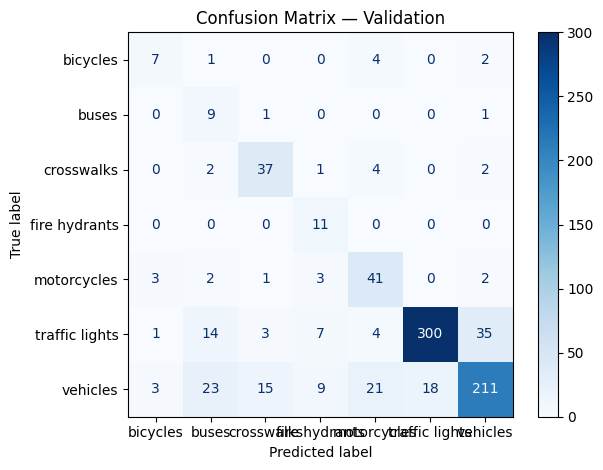

  Training with C=0.001...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 79.82%
  Training with C=0.01...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 76.94%
  Training with C=0.1...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 74.81%
  Training with C=1.0...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 73.81%
  Training with C=10.0...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 70.80%
  Training with C=100.0...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    → Validation Accuracy: 70.05%

🏆 Best C value: 0.001 with accuracy: 79.82%


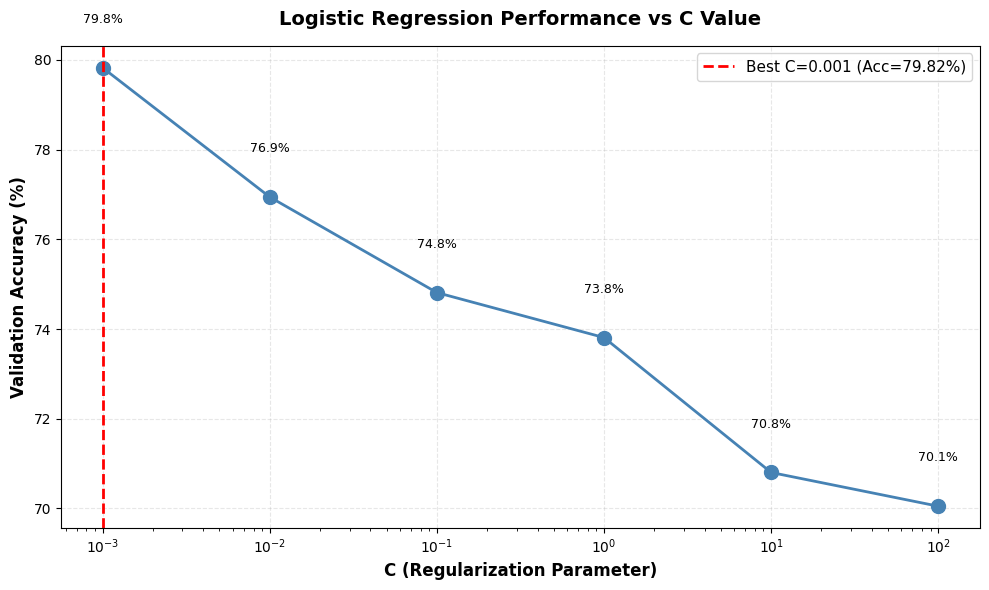


✓ Optimal C value identified!

Note:
  - Smaller C = More regularization (simpler model)
  - Larger C = Less regularization (more complex model)
  - Best C balances bias and variance!

✓ Grid search completed and best estimator evaluated!

Notes:
  - Smaller C = Stronger regularization (simpler model).
  - Larger C = Weaker regularization (more complex model).
  - Best C (and other params) balance bias–variance for your data.


In [ ]:


from sklearn.model_selection import GridSearchCV, StratifiedKFold, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


print("🔍 Grid search over Logistic Regression hyperparameters...")
print("This will train multiple models with cross-validation.\n")

# ====== Parameter Grid (compatible with lbfgs + multinomial) ======
param_grid = {
    "C":       [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # inverse regularization
    "tol":     [1e-4, 1e-3],                          # convergence tolerance
    "fit_intercept": [True, False],                   # with or without intercept
    "class_weight":  [None, "balanced"],              # handle imbalance
    # Keep these fixed; they describe the model family you requested:
    # "solver": ["lbfgs"], "multi_class": ["multinomial"], "penalty": ["l2"]
    # We'll set them directly on the estimator below.
}

# ====== Base estimator ======
base_lr = LogisticRegression(
    multi_class='multinomial',    # Multinomial for multi-class classification
    solver='lbfgs',               # L-BFGS (supports L2)
    penalty='l2',                 # fixed: only L2 is valid with lbfgs
    max_iter=1000,                # you can tune this too if you want
    random_state=42,
    verbose=0                     # use 1 to see per-iteration convergence logs
)

# ====== Cross-validation plan ======
cv_splits = 5
cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

# ====== Grid Search ======
gs = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    scoring="accuracy",           # or 'f1_macro' for imbalanced multi-class
    cv=cv,
    n_jobs=-1,                    # use all cores
    refit=True,                   # refit on full training with best params
    verbose=1
)

gs.fit(X_train_scaled, y_train)

# ====== Results summary ======
print("\n" + "="*70)
print("🏆 GRID SEARCH — BEST RESULT")
print("="*70)
print(f"Best CV Accuracy: {gs.best_score_:.4f} (mean over {cv_splits} folds)")
print("Best Params:")
for k, v in gs.best_params_.items():
    print(f"  • {k}: {v}")

best_lr = gs.best_estimator_
try:
    n_iter = best_lr.n_iter_[0]
except Exception:
    n_iter = None

print("\nMODEL CONFIG (best estimator)")
print("-"*70)
print(f"  Model Type: Logistic Regression (multinomial)")
print(f"  Solver: {best_lr.solver}")
print(f"  Penalty: {best_lr.penalty}")
print(f"  C (Inverse Reg Strength): {best_lr.C}")
print(f"  λ (Reg Strength = 1/C): {1.0 / best_lr.C:.6f}")
print(f"  tol: {best_lr.tol}")
print(f"  fit_intercept: {best_lr.fit_intercept}")
print(f"  class_weight: {best_lr.class_weight}")
print(f"  max_iter: {best_lr.max_iter}")
if n_iter is not None:
    print(f"  Iterations until convergence: {n_iter}")
print("-"*70)

# ====== Tabular CV results (sorted) ======
cv_results = pd.DataFrame(gs.cv_results_)
cols_to_show = [
    "mean_test_score", "std_test_score", "params", "rank_test_score"
]
cv_results_sorted = cv_results.sort_values("rank_test_score")[cols_to_show]
print("\nCV RESULTS (top 10):")
print(cv_results_sorted.head(10).to_string(index=False))

# ====== Validation metrics on your hold-out set ======
print("\n" + "="*70)
print("📏 VALIDATION SET PERFORMANCE")
print("="*70)
y_valid_pred = best_lr.predict(X_valid_scaled)
acc_valid = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {acc_valid:.4f}\n")

# Per-class report (if class_names provided)
try:
    print(classification_report(y_valid, y_valid_pred, target_names=class_names, digits=4))
except Exception:
    print(classification_report(y_valid, y_valid_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred, labels=best_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=getattr(best_lr, "classes_", None))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Validation")
plt.tight_layout()
plt.show()


c_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
accuracies = []

for c in c_values:
    print(f"  Training with C={c}...")

    # Create and train model with this C value
    lr_temp = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=c,
        random_state=42,
        verbose=0  # Suppress output for cleaner display
    )

    lr_temp.fit(X_train_scaled, y_train)

    # Predict on validation set
    y_pred = lr_temp.predict(X_valid_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_valid, y_pred)
    accuracies.append(acc)

    print(f"    → Validation Accuracy: {acc*100:.2f}%")

# Find best C value
best_c = c_values[np.argmax(accuracies)]
best_acc = max(accuracies)

print("\n" + "="*60)
print(f"🏆 Best C value: {best_c} with accuracy: {best_acc*100:.2f}%")
print("="*60)

# Visualize results
plt.figure(figsize=(10, 6))
plt.semilogx(c_values, [acc*100 for acc in accuracies],
             marker='o', linewidth=2, markersize=10, color='steelblue')
plt.xlabel('C (Regularization Parameter)', fontweight='bold', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
plt.title('Logistic Regression Performance vs C Value',
          fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, linestyle='--')

# Mark best C
plt.axvline(x=best_c, color='red', linestyle='--', linewidth=2,
            label=f'Best C={best_c} (Acc={best_acc*100:.2f}%)')

# Add percentage labels
for c, acc in zip(c_values, accuracies):
    plt.text(c, acc*100 + 1, f'{acc*100:.1f}%', ha='center', fontsize=9)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n✓ Optimal C value identified!")
print("\nNote:")
print("  - Smaller C = More regularization (simpler model)")
print("  - Larger C = Less regularization (more complex model)")
print("  - Best C balances bias and variance!")
print("\n✓ Grid search completed and best estimator evaluated!")
print("\nNotes:")
print("  - Smaller C = Stronger regularization (simpler model).")
print("  - Larger C = Weaker regularization (more complex model).")
print("  - Best C (and other params) balance bias–variance for your data.")


# combine both the train+valid set and train the mdoel on this

In [ ]:
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)

In [ ]:
final_lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    C=best_c,
    random_state=42,
    verbose=1
)

print("Training in progress...")
print()

# Train the model
final_lr_model.fit(X_full, y_full)

print()
print("✓ Final model trained successfully!")
print()
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"  Model Type: Logistic Regression (Multinomial)")
print(f"  Solver: L-BFGS")
print(f"  Optimal C: {best_c}")
print(f"  Training samples: {len(X_full)}")
print(f"  Features per sample: {X_full.shape[1]}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Expected validation accuracy: {best_acc*100:.2f}%")
print(f"  Iterations to convergence: {final_lr_model.n_iter_[0]}")
print("="*60)
print()
print("The final model is ready for testing! 🚀")

Training in progress...



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✓ Final model trained successfully!

FINAL MODEL SUMMARY
  Model Type: Logistic Regression (Multinomial)
  Solver: L-BFGS
  Optimal C: 0.001
  Training samples: 2529
  Features per sample: 1794
  Number of classes: 7
  Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  Expected validation accuracy: 79.82%
  Iterations to convergence: 1000

The final model is ready for testing! 🚀


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


In [ ]:
print("📊 Final evaluation on test set...")
print("This is the moment of truth! 🎯\n")

# Make predictions
print("⏳ Making predictions on test images...")
y_test_pred =  lr_model.predict(X_test_scaled)
print("✓ Predictions complete!\n")

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display results
print("="*60)
print("🏆 FINAL TEST RESULTS")
print("="*60)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Correct Predictions: {int(test_accuracy * len(y_test))}/{len(y_test)}")
print(f"Incorrect Predictions: {len(y_test) - int(test_accuracy * len(y_test))}/{len(y_test)}")
print("="*60)

# Compare with validation
print(f"\n📊 Performance Comparison:")
print(f"  Validation Accuracy: {best_acc*100:.2f}%")
print(f"  Test Accuracy:       {test_accuracy*100:.2f}%")

difference = test_accuracy - best_acc
if abs(difference) < 0.02:
    print(f"  ✓ Consistent! (Difference: {abs(difference)*100:.2f}%)")
elif test_accuracy < best_acc:
    print(f"  ⚠ Test is {abs(difference)*100:.2f}% lower")
    print("    → Possible slight overfitting")
else:
    print(f"  ✓ Test is {difference*100:.2f}% higher (excellent!)")

# Detailed classification report
print("\n📊 Detailed Test Classification Report:")
print("-"*60)
print(classification_report(y_test, y_test_pred))

print("\n" + "="*60)
print("This is your model's REAL-WORLD performance! 🎉")
print("="*60)

📊 Final evaluation on test set...
This is the moment of truth! 🎯

⏳ Making predictions on test images...
✓ Predictions complete!

🏆 FINAL TEST RESULTS
Test Accuracy: 64.82%
Correct Predictions: 328/506
Incorrect Predictions: 178/506

📊 Performance Comparison:
  Validation Accuracy: 79.82%
  Test Accuracy:       64.82%
  ⚠ Test is 15.00% lower
    → Possible slight overfitting

📊 Detailed Test Classification Report:
------------------------------------------------------------
                precision    recall  f1-score   support

      bicycles       0.62      0.23      0.33        22
         buses       0.33      0.50      0.40        12
    crosswalks       0.89      0.80      0.84        81
 fire hydrants       0.67      0.35      0.46        23
   motorcycles       0.33      0.57      0.42        30
traffic lights       0.68      0.64      0.66       129
      vehicles       0.65      0.69      0.67       209

      accuracy                           0.65       506
     macro avg

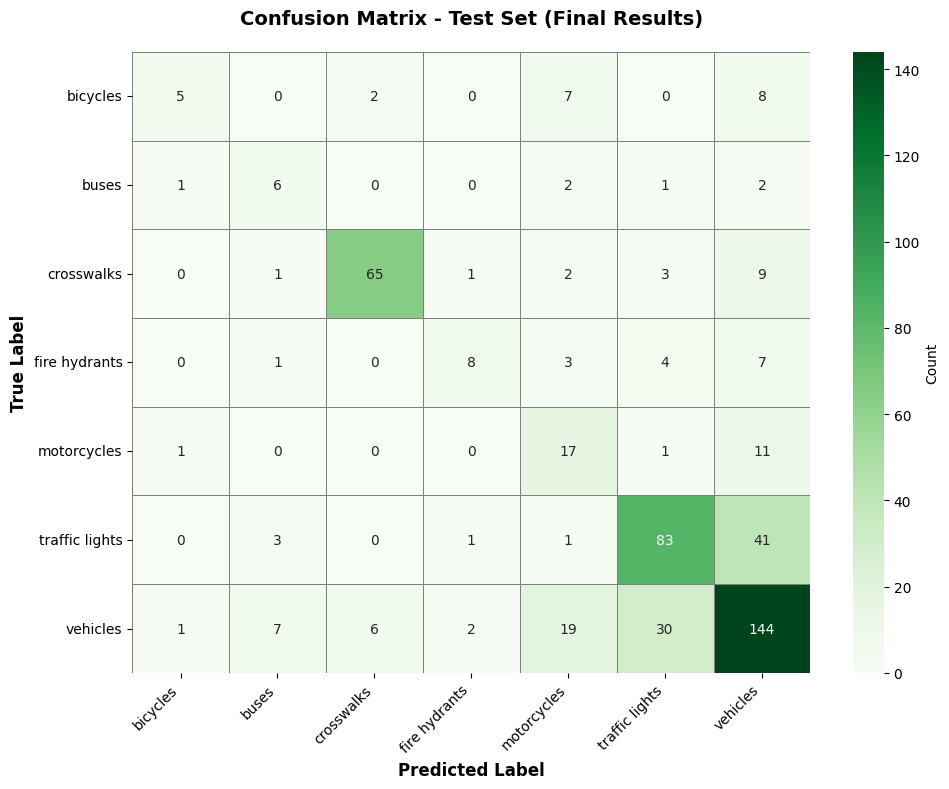

✓ Test confusion matrix displayed!

📈 Per-Class Analysis from Confusion Matrix:
------------------------------------------------------------
  bicycles            :  22.7% (  5/ 22 correct)
  buses               :  50.0% (  6/ 12 correct)
  crosswalks          :  80.2% ( 65/ 81 correct)
  fire hydrants       :  34.8% (  8/ 23 correct)
  motorcycles         :  56.7% ( 17/ 30 correct)
  traffic lights      :  64.3% ( 83/129 correct)
  vehicles            :  68.9% (144/209 correct)
------------------------------------------------------------

✓ Look for the darkest green cells = Best predictions!


In [ ]:

# Compute confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=class_names)

# Create visualization
plt.figure(figsize=(10, 8))

# Use green color scheme for final results
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)

# Titles and labels
plt.title('Confusion Matrix - Test Set (Final Results)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

print("✓ Test confusion matrix displayed!")

# Analyze the confusion matrix
print("\n📈 Per-Class Analysis from Confusion Matrix:")
print("-"*60)
for i, class_name in enumerate(class_names):
    total_true = cm_test[i, :].sum()      # Total actual examples
    correct = cm_test[i, i]                # Correctly predicted

    if total_true > 0:
        class_acc = (correct / total_true) * 100
        print(f"  {class_name:20s}: {class_acc:5.1f}% ({correct:3d}/{total_true:3d} correct)")
print("-"*60)

print("\n✓ Look for the darkest green cells = Best predictions!")

# manuall test on some samples

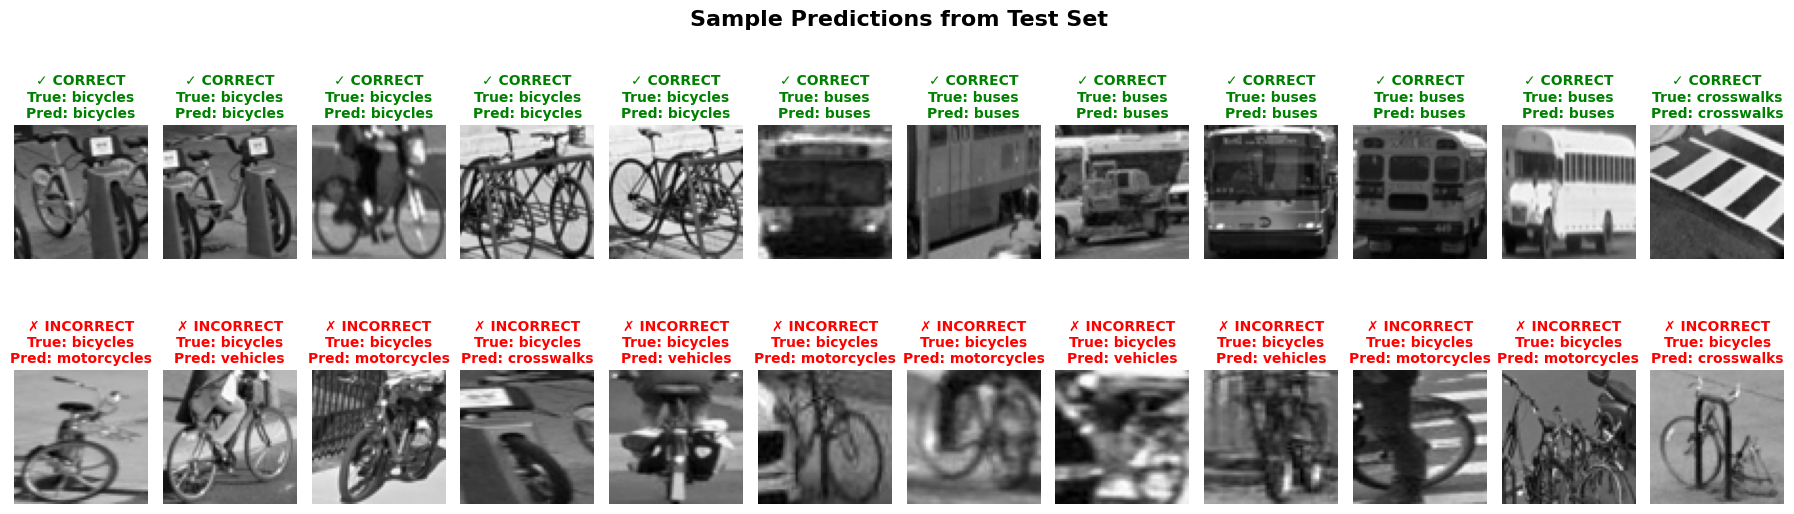

✓ Visualization complete!

💡 Analysis Tips:
  • Are incorrect predictions visually similar to predicted class?
  • Do mistakes make sense from a human perspective?
  • Are certain classes consistently problematic?


In [ ]:
num_samples = 12

# Create figure with 2 rows
fig, axes = plt.subplots(2, num_samples, figsize=(18, 6))
fig.suptitle('Sample Predictions from Test Set',
             fontsize=16, fontweight='bold')

# ===== TOP ROW: CORRECT PREDICTIONS =====
correct_indices = [i for i in range(len(y_test)) if y_test[i] == y_test_pred[i]]

if len(correct_indices) > 0:
    for i in range(min(num_samples, len(correct_indices))):
        idx = correct_indices[i]
        img = test_images[idx]

        # Display image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(
            f'✓ CORRECT\nTrue: {y_test[idx]}\nPred: {y_test_pred[idx]}',
            color='green',
            fontweight='bold',
            fontsize=10
        )
        axes[0, i].axis('off')
else:
    print("Warning: No correct predictions found!")

# ===== BOTTOM ROW: INCORRECT PREDICTIONS =====
incorrect_indices = [i for i in range(len(y_test)) if y_test[i] != y_test_pred[i]]

if len(incorrect_indices) > 0:
    for i in range(min(num_samples, len(incorrect_indices))):
        idx = incorrect_indices[i]
        img = test_images[idx]

        # Display image
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(
            f'✗ INCORRECT\nTrue: {y_test[idx]}\nPred: {y_test_pred[idx]}',
            color='red',
            fontweight='bold',
            fontsize=10
        )
        axes[1, i].axis('off')
else:
    print("🎉 No incorrect predictions! Perfect score!")
    # Hide bottom row if perfect
    for i in range(num_samples):
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")
print("\n💡 Analysis Tips:")
print("  • Are incorrect predictions visually similar to predicted class?")
print("  • Do mistakes make sense from a human perspective?")
print("  • Are certain classes consistently problematic?")

  bicycles            :  22.7% (  5/ 22)
  buses               :  50.0% (  6/ 12)
  crosswalks          :  80.2% ( 65/ 81)
  fire hydrants       :  34.8% (  8/ 23)
  motorcycles         :  56.7% ( 17/ 30)
  traffic lights      :  64.3% ( 83/129)
  vehicles            :  68.9% (144/209)



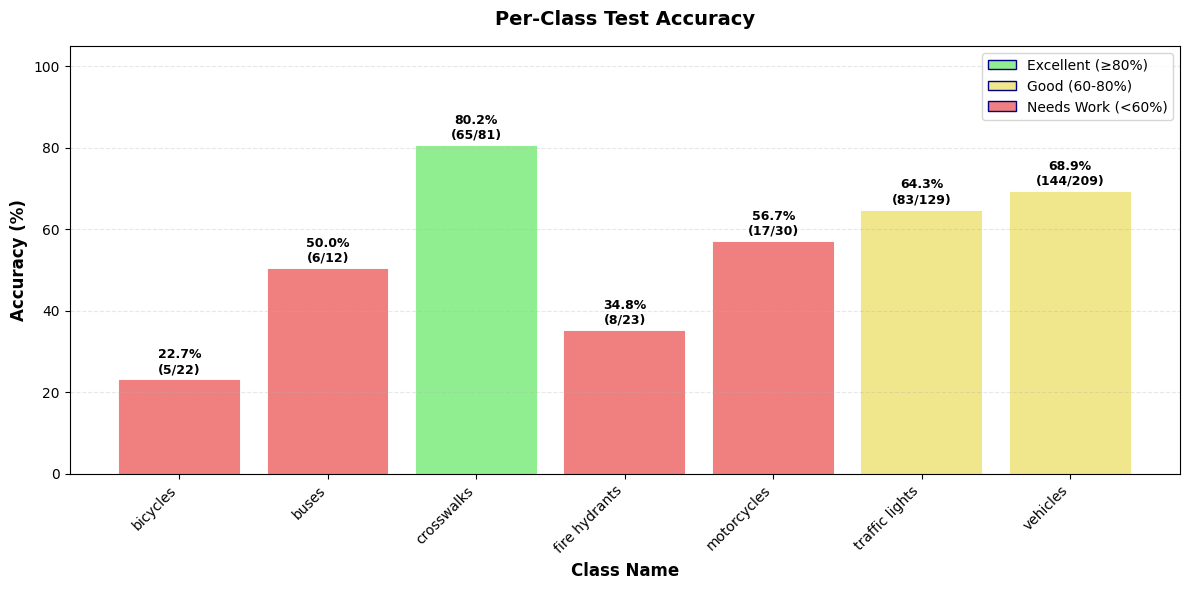


✓ Per-class analysis complete!

💡 Insights:
  • Green bars = Model performs well
  • Red bars = Challenging classes, need attention
  • Consider collecting more training data for weak classes


In [ ]:
class_accuracies = {}
class_details = {}

for class_name in class_names:
    # Find all test examples of this class
    class_indices = [i for i in range(len(y_test)) if y_test[i] == class_name]

    if len(class_indices) > 0:
        # Count correct predictions
        class_correct = sum([1 for i in class_indices if y_test[i] == y_test_pred[i]])
        class_total = len(class_indices)
        class_acc = class_correct / class_total

        # Store results
        class_accuracies[class_name] = class_acc
        class_details[class_name] = (class_correct, class_total)

        # Print details
        print(f"  {class_name:20s}: {class_acc*100:5.1f}% ({class_correct:3d}/{class_total:3d})")

print()

# Visualize per-class accuracy
plt.figure(figsize=(12, 6))

# Create bars
bars = plt.bar(
    class_accuracies.keys(),
    [acc*100 for acc in class_accuracies.values()],
    color='skyblue',
    edgecolor='navy',
    linewidth=1.5
)

# Color code: Green (≥80%), Yellow (60-80%), Red (<60%)
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    if acc >= 0.8:
        bars[i].set_color('lightgreen')
    elif acc >= 0.6:
        bars[i].set_color('khaki')
    else:
        bars[i].set_color('lightcoral')

# Labels
plt.xlabel('Class Name', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold', pad=15)
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    correct, total = class_details[class_name]
    plt.text(i, acc*100 + 2, f'{acc*100:.1f}%\n({correct}/{total})',
             ha='center', fontweight='bold', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='navy', label='Excellent (≥80%)'),
    Patch(facecolor='khaki', edgecolor='navy', label='Good (60-80%)'),
    Patch(facecolor='lightcoral', edgecolor='navy', label='Needs Work (<60%)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Per-class analysis complete!")
print("\n Insights:")
print("  • Green bars = Model performs well")
print("  • Red bars = Challenging classes, need attention")
print("  • Consider collecting more training data for weak classes")